In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.applications import InceptionResNetV2

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [3]:
train_dir = 'data-ICIAR/Reinhard/train/'
test_dir = "data-ICIAR/Reinhard/test/"

extracted_features_dir = "extracted_features/"
model_name = "Reinhard_InceptionV4_concate"

In [4]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.9.0
dim_ordering: tf


In [5]:
batch_size = 32
img_height, img_width = 512, 512
input_shape = (img_height, img_width, 3)
epochs = 1000

In [6]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

# print("*"*30)
# for root,dirs,files in os.walk(validation_dir):
#     print (root, len(files))
    
print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data-ICIAR/Reinhard/train/ 0
data-ICIAR/Reinhard/train/Benign 1155
data-ICIAR/Reinhard/train/InSitu 1155
data-ICIAR/Reinhard/train/Invasive 1155
data-ICIAR/Reinhard/train/Normal 1155
******************************
data-ICIAR/Reinhard/test/ 0
data-ICIAR/Reinhard/test/Benign 25
data-ICIAR/Reinhard/test/InSitu 25
data-ICIAR/Reinhard/test/Invasive 25
data-ICIAR/Reinhard/test/Normal 25


In [7]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

# test_generator_without_aug = test_datagen.flow_from_directory(
#     test_dir_whithout_aug,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     seed = random_seed,
#     shuffle = False,
#     class_mode='categorical')

Found 3468 images belonging to 4 classes.
Found 1152 images belonging to 4 classes.
Found 100 images belonging to 4 classes.


In [8]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 3468
nb_validation_samples: 1152

predict_size_train: 109
predict_size_validation: 36
nb_test_samples: 100
predict_size_test: 4

 num_classes: 4


In [9]:
from keras.backend.tensorflow_backend import get_session
from keras.backend.tensorflow_backend import clear_session
from keras.backend.tensorflow_backend import set_session

def reset_keras_tf_session():
    """
    this function clears the gpu memory and set the 
    tf session to not use the whole gpu
    """
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))


reset_keras_tf_session()

In [10]:
'''
Copyright 2017 TensorFlow Authors and Kent Sommer

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

   http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
'''
import numpy as np

# Sys
import warnings
# Keras Core
from keras.layers.convolutional import MaxPooling2D, Convolution2D, AveragePooling2D
from keras.layers import Input, Dropout, Dense, Flatten, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras import regularizers
from keras import initializers
from keras.models import Model
# Backend
from keras import backend as K
# Utils
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.utils.data_utils import get_file


#########################################################################################
# Implements the Inception Network v4 (http://arxiv.org/pdf/1602.07261v1.pdf) in Keras. #
#########################################################################################

WEIGHTS_PATH = 'https://github.com/kentsommer/keras-inceptionV4/releases/download/2.1/inception-v4_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/kentsommer/keras-inceptionV4/releases/download/2.1/inception-v4_weights_tf_dim_ordering_tf_kernels_notop.h5'


def preprocess_input(x):
    x = np.divide(x, 255.0)
    x = np.subtract(x, 0.5)
    x = np.multiply(x, 2.0)
    return x


def conv2d_bn(x, nb_filter, num_row, num_col,
              padding='same', strides=(1, 1), use_bias=False):
    """
    Utility function to apply conv + BN. 
    (Slightly modified from https://github.com/fchollet/keras/blob/master/keras/applications/inception_v3.py)
    """
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1
    x = Convolution2D(nb_filter, (num_row, num_col),
                      strides=strides,
                      padding=padding,
                      use_bias=use_bias,
                      kernel_regularizer=regularizers.l2(0.00004),
                      kernel_initializer=initializers.VarianceScaling(scale=2.0, mode='fan_in', distribution='normal', seed=None))(x)
    x = BatchNormalization(axis=channel_axis, momentum=0.9997, scale=False)(x)
    x = Activation('relu')(x)
    return x


def block_inception_a(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 96, 1, 1)

    branch_1 = conv2d_bn(input, 64, 1, 1)
    branch_1 = conv2d_bn(branch_1, 96, 3, 3)

    branch_2 = conv2d_bn(input, 64, 1, 1)
    branch_2 = conv2d_bn(branch_2, 96, 3, 3)
    branch_2 = conv2d_bn(branch_2, 96, 3, 3)

    branch_3 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 96, 1, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x


def block_reduction_a(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 384, 3, 3, strides=(2,2), padding='valid')

    branch_1 = conv2d_bn(input, 192, 1, 1)
    branch_1 = conv2d_bn(branch_1, 224, 3, 3)
    branch_1 = conv2d_bn(branch_1, 256, 3, 3, strides=(2,2), padding='valid')

    branch_2 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(input)

    x = concatenate([branch_0, branch_1, branch_2], axis=channel_axis)
    return x


def block_inception_b(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 384, 1, 1)

    branch_1 = conv2d_bn(input, 192, 1, 1)
    branch_1 = conv2d_bn(branch_1, 224, 1, 7)
    branch_1 = conv2d_bn(branch_1, 256, 7, 1)

    branch_2 = conv2d_bn(input, 192, 1, 1)
    branch_2 = conv2d_bn(branch_2, 192, 7, 1)
    branch_2 = conv2d_bn(branch_2, 224, 1, 7)
    branch_2 = conv2d_bn(branch_2, 224, 7, 1)
    branch_2 = conv2d_bn(branch_2, 256, 1, 7)

    branch_3 = AveragePooling2D((3,3), strides=(1,1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 128, 1, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x


def block_reduction_b(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 192, 1, 1)
    branch_0 = conv2d_bn(branch_0, 192, 3, 3, strides=(2, 2), padding='valid')

    branch_1 = conv2d_bn(input, 256, 1, 1)
    branch_1 = conv2d_bn(branch_1, 256, 1, 7)
    branch_1 = conv2d_bn(branch_1, 320, 7, 1)
    branch_1 = conv2d_bn(branch_1, 320, 3, 3, strides=(2,2), padding='valid')

    branch_2 = MaxPooling2D((3, 3), strides=(2, 2), padding='valid')(input)

    x = concatenate([branch_0, branch_1, branch_2], axis=channel_axis)
    return x


def block_inception_c(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    branch_0 = conv2d_bn(input, 256, 1, 1)

    branch_1 = conv2d_bn(input, 384, 1, 1)
    branch_10 = conv2d_bn(branch_1, 256, 1, 3)
    branch_11 = conv2d_bn(branch_1, 256, 3, 1)
    branch_1 = concatenate([branch_10, branch_11], axis=channel_axis)


    branch_2 = conv2d_bn(input, 384, 1, 1)
    branch_2 = conv2d_bn(branch_2, 448, 3, 1)
    branch_2 = conv2d_bn(branch_2, 512, 1, 3)
    branch_20 = conv2d_bn(branch_2, 256, 1, 3)
    branch_21 = conv2d_bn(branch_2, 256, 3, 1)
    branch_2 = concatenate([branch_20, branch_21], axis=channel_axis)

    branch_3 = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(input)
    branch_3 = conv2d_bn(branch_3, 256, 1, 1)

    x = concatenate([branch_0, branch_1, branch_2, branch_3], axis=channel_axis)
    return x


def inception_v4_base(input):
    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = -1

    # Input Shape is 299 x 299 x 3 (th) or 3 x 299 x 299 (th)
    net = conv2d_bn(input, 32, 3, 3, strides=(2,2), padding='valid')
    net = conv2d_bn(net, 32, 3, 3, padding='valid')
    net = conv2d_bn(net, 64, 3, 3)

    branch_0 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)

    branch_1 = conv2d_bn(net, 96, 3, 3, strides=(2,2), padding='valid')

    net = concatenate([branch_0, branch_1], axis=channel_axis)

    branch_0 = conv2d_bn(net, 64, 1, 1)
    branch_0 = conv2d_bn(branch_0, 96, 3, 3, padding='valid')

    branch_1 = conv2d_bn(net, 64, 1, 1)
    branch_1 = conv2d_bn(branch_1, 64, 1, 7)
    branch_1 = conv2d_bn(branch_1, 64, 7, 1)
    branch_1 = conv2d_bn(branch_1, 96, 3, 3, padding='valid')

    net = concatenate([branch_0, branch_1], axis=channel_axis)

    branch_0 = conv2d_bn(net, 192, 3, 3, strides=(2,2), padding='valid')
    branch_1 = MaxPooling2D((3,3), strides=(2,2), padding='valid')(net)

    net = concatenate([branch_0, branch_1], axis=channel_axis)

    # 35 x 35 x 384
    # 4 x Inception-A blocks
    for idx in range(4):
    	net = block_inception_a(net)

    # 35 x 35 x 384
    # Reduction-A block
    net = block_reduction_a(net)

    # 17 x 17 x 1024
    # 7 x Inception-B blocks
    for idx in range(7):
    	net = block_inception_b(net)

    # 17 x 17 x 1024
    # Reduction-B block
    net = block_reduction_b(net)

    # 8 x 8 x 1536
    # 3 x Inception-C blocks
    for idx in range(3):
    	net = block_inception_c(net)

    return net


def inception_v4(num_classes, dropout_keep_prob, weights, include_top):
    '''
    Creates the inception v4 network

    Args:
    	num_classes: number of classes
    	dropout_keep_prob: float, the fraction to keep before final layer.
    
    Returns: 
    	logits: the logits outputs of the model.
    '''

    # Input Shape is 299 x 299 x 3 (tf) or 3 x 299 x 299 (th)
    if K.image_data_format() == 'channels_first':
        inputs = Input((3, 512, 512))
    else:
        inputs = Input((512, 512, 3))

    # Make inception base
    x = inception_v4_base(inputs)


    # Final pooling and prediction
    if include_top:
        # 1 x 1 x 1536
        x = AveragePooling2D((8,8), padding='valid')(x)
        x = Dropout(dropout_keep_prob)(x)
        x = Flatten()(x)
        # 1536
        x = Dense(units=num_classes, activation=tf.nn.softmax)(x)

    model = Model(inputs, x, name='inception_v4')

    # load weights
    if weights == 'imagenet':
        if K.image_data_format() == 'channels_first':
            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
        if include_top:
            weights_path = get_file(
                'inception-v4_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                md5_hash='9fe79d77f793fe874470d84ca6ba4a3b')
        else:
            weights_path = get_file(
                'inception-v4_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                md5_hash='9296b46b5971573064d12e4669110969')
        model.load_weights(weights_path, by_name=True)
    return model

In [11]:
def create_model(num_classes=num_classes, dropout_prob=0.2, weights=None, include_top=True):
    return inception_v4(num_classes, dropout_prob, weights, include_top)

In [12]:
model = create_model(weights='imagenet', include_top=False)

In [13]:
# model = InceptionResNetV2(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=Input(shape=input_shape))

In [14]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 conv2d_4
11 batch_normalization_4
12 max_pooling2d_1
13 activation_4
14 concatenate_1
15 conv2d_7
16 batch_normalization_7
17 activation_7
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_5
22 conv2d_9
23 batch_normalization_5
24 batch_normalization_9
25 activation_5
26 activation_9
27 conv2d_6
28 conv2d_10
29 batch_normalization_6
30 batch_normalization_10
31 activation_6
32 activation_10
33 concatenate_2
34 conv2d_11
35 batch_normalization_11
36 activation_11
37 max_pooling2d_2
38 concatenate_3
39 conv2d_15
40 batch_normalization_15
41 activation_15
42 conv2d_13
43 conv2d_16
44 batch_normalization_13
45 batch_normalization_16
46 activation_13
47 activation_16
48 average_pooling2d_1
49 conv2d_12
50 conv2d_14
51 conv2d_17
52 conv2d_18
53 batch_normalization_12
54 batch_normalization_14
55 batch_normalization_17


In [15]:
# print(model.layers[11].name)

In [16]:
c1 = model.layers[15].output 
c1 = GlobalAveragePooling2D()(c1)       

c2 = model.layers[39].output
c2 = GlobalAveragePooling2D()(c2)       

c3 = model.layers[145].output
c3 = GlobalAveragePooling2D()(c3)       

c4 = model.layers[389].output
c4 = GlobalAveragePooling2D()(c4) 

con = concatenate([c1, c2, c3, c4])

bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [17]:
bottleneck_final_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 255, 255, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 255, 255, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 255, 255, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [18]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [19]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [20]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [21]:
dropout_rate = 0.5

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.001, beta_1=0.6, beta_2=0.8, amsgrad=True)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 3468 samples, validate on 1152 samples
Epoch 1/1000
 - 2s - loss: 1.1884 - acc: 0.4911 - val_loss: 0.8762 - val_acc: 0.6866
Epoch 2/1000
 - 0s - loss: 0.8818 - acc: 0.6436 - val_loss: 0.7149 - val_acc: 0.7569
Epoch 3/1000
 - 0s - loss: 0.7509 - acc: 0.7200 - val_loss: 0.6535 - val_acc: 0.7665
Epoch 4/1000
 - 0s - loss: 0.6867 - acc: 0.7488 - val_loss: 0.5692 - val_acc: 0.8030
Epoch 5/1000
 - 0s - loss: 0.6302 - acc: 0.7702 - val_loss: 0.5685 - val_acc: 0.8003
Epoch 6/1000
 - 0s - loss: 0.5801 - acc: 0.7915 - val_loss: 0.4882 - val_acc: 0.8333
Epoch 7/1000
 - 0s - loss: 0.5331 - acc: 0.8129 - val_loss: 0.4530 - val_acc: 0.8672
Epoch 8/1000
 - 0s - loss: 0.5173 - acc: 0.8189 - val_loss: 0.4832 - val_acc: 0.8307
Epoch 9/1000
 - 0s - loss: 0.4819 - acc: 0.8345 - val_loss: 0.4205 - val_acc: 0.8481
Epoch 10/1000
 - 0s - loss: 0.4612 - acc: 0.8379 - val_loss: 0.3982 - val_acc: 0.8655
Epoch 11/1000
 - 0s - loss: 0.4374 - acc: 0.8489 - val_loss: 0.4302 - val_acc: 0.8273
Epoch 12/1000
 

Epoch 96/1000
 - 0s - loss: 0.0642 - acc: 0.9873 - val_loss: 0.0411 - val_acc: 0.9922
Epoch 97/1000
 - 0s - loss: 0.0665 - acc: 0.9873 - val_loss: 0.0391 - val_acc: 0.9965
Epoch 98/1000
 - 0s - loss: 0.0678 - acc: 0.9853 - val_loss: 0.0584 - val_acc: 0.9905
Epoch 99/1000
 - 0s - loss: 0.0640 - acc: 0.9862 - val_loss: 0.0371 - val_acc: 0.9957
Epoch 100/1000
 - 0s - loss: 0.0651 - acc: 0.9856 - val_loss: 0.0394 - val_acc: 0.9974
Epoch 101/1000
 - 0s - loss: 0.0645 - acc: 0.9873 - val_loss: 0.0333 - val_acc: 0.9965
Epoch 102/1000
 - 0s - loss: 0.0607 - acc: 0.9882 - val_loss: 0.0364 - val_acc: 0.9957
Epoch 103/1000
 - 0s - loss: 0.0543 - acc: 0.9911 - val_loss: 0.0338 - val_acc: 0.9974
Epoch 104/1000
 - 0s - loss: 0.0633 - acc: 0.9873 - val_loss: 0.0324 - val_acc: 0.9957
Epoch 105/1000
 - 0s - loss: 0.0603 - acc: 0.9850 - val_loss: 0.0369 - val_acc: 0.9974
Epoch 106/1000
 - 0s - loss: 0.0605 - acc: 0.9890 - val_loss: 0.0304 - val_acc: 0.9983
Epoch 107/1000
 - 0s - loss: 0.0584 - acc: 0.98

Epoch 191/1000
 - 0s - loss: 0.0304 - acc: 0.9945 - val_loss: 0.0164 - val_acc: 0.9965
Epoch 192/1000
 - 0s - loss: 0.0285 - acc: 0.9957 - val_loss: 0.0130 - val_acc: 1.0000
Epoch 193/1000
 - 0s - loss: 0.0301 - acc: 0.9957 - val_loss: 0.0143 - val_acc: 0.9991
Epoch 194/1000
 - 0s - loss: 0.0271 - acc: 0.9965 - val_loss: 0.0132 - val_acc: 0.9991
Epoch 195/1000
 - 0s - loss: 0.0282 - acc: 0.9945 - val_loss: 0.0180 - val_acc: 0.9983
Epoch 196/1000
 - 0s - loss: 0.0293 - acc: 0.9957 - val_loss: 0.0209 - val_acc: 0.9948
Epoch 197/1000
 - 0s - loss: 0.0273 - acc: 0.9968 - val_loss: 0.0134 - val_acc: 0.9991
Epoch 198/1000
 - 0s - loss: 0.0287 - acc: 0.9951 - val_loss: 0.0132 - val_acc: 1.0000
Epoch 199/1000
 - 0s - loss: 0.0284 - acc: 0.9960 - val_loss: 0.0140 - val_acc: 0.9991
Epoch 200/1000
 - 0s - loss: 0.0257 - acc: 0.9965 - val_loss: 0.0139 - val_acc: 0.9991
Epoch 201/1000
 - 0s - loss: 0.0272 - acc: 0.9971 - val_loss: 0.0120 - val_acc: 1.0000
Epoch 202/1000
 - 0s - loss: 0.0236 - acc: 

 - 0s - loss: 0.0182 - acc: 0.9965 - val_loss: 0.0110 - val_acc: 0.9991
Epoch 286/1000
 - 0s - loss: 0.0159 - acc: 0.9991 - val_loss: 0.0080 - val_acc: 0.9991
Epoch 287/1000
 - 0s - loss: 0.0157 - acc: 0.9983 - val_loss: 0.0078 - val_acc: 1.0000
Epoch 288/1000
 - 0s - loss: 0.0165 - acc: 0.9974 - val_loss: 0.0115 - val_acc: 0.9974
Epoch 289/1000
 - 0s - loss: 0.0180 - acc: 0.9971 - val_loss: 0.0091 - val_acc: 1.0000
Epoch 290/1000
 - 0s - loss: 0.0179 - acc: 0.9974 - val_loss: 0.0080 - val_acc: 1.0000
Epoch 291/1000
 - 0s - loss: 0.0145 - acc: 0.9980 - val_loss: 0.0078 - val_acc: 1.0000
Epoch 292/1000
 - 0s - loss: 0.0165 - acc: 0.9983 - val_loss: 0.0078 - val_acc: 1.0000
Epoch 293/1000
 - 0s - loss: 0.0157 - acc: 0.9977 - val_loss: 0.0077 - val_acc: 1.0000
Epoch 294/1000
 - 0s - loss: 0.0151 - acc: 0.9988 - val_loss: 0.0091 - val_acc: 1.0000
Epoch 295/1000
 - 0s - loss: 0.0161 - acc: 0.9988 - val_loss: 0.0067 - val_acc: 1.0000
Epoch 296/1000
 - 0s - loss: 0.0156 - acc: 0.9980 - val_lo

Epoch 380/1000
 - 0s - loss: 0.0122 - acc: 0.9983 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 381/1000
 - 0s - loss: 0.0111 - acc: 0.9983 - val_loss: 0.0063 - val_acc: 1.0000
Epoch 382/1000
 - 0s - loss: 0.0115 - acc: 0.9991 - val_loss: 0.0061 - val_acc: 1.0000
Epoch 383/1000
 - 0s - loss: 0.0106 - acc: 0.9991 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 384/1000
 - 0s - loss: 0.0110 - acc: 0.9980 - val_loss: 0.0055 - val_acc: 1.0000
Epoch 385/1000
 - 0s - loss: 0.0120 - acc: 0.9983 - val_loss: 0.0058 - val_acc: 1.0000
Epoch 386/1000
 - 0s - loss: 0.0114 - acc: 0.9983 - val_loss: 0.0053 - val_acc: 1.0000
Epoch 387/1000
 - 0s - loss: 0.0111 - acc: 0.9986 - val_loss: 0.0051 - val_acc: 1.0000
Epoch 388/1000
 - 0s - loss: 0.0094 - acc: 0.9991 - val_loss: 0.0066 - val_acc: 1.0000
Epoch 389/1000
 - 0s - loss: 0.0127 - acc: 0.9986 - val_loss: 0.0050 - val_acc: 1.0000
Epoch 390/1000
 - 0s - loss: 0.0102 - acc: 0.9983 - val_loss: 0.0049 - val_acc: 1.0000
Epoch 391/1000
 - 0s - loss: 0.0118 - acc: 

 - 0s - loss: 0.0076 - acc: 0.9991 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 475/1000
 - 0s - loss: 0.0093 - acc: 0.9980 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 476/1000
 - 0s - loss: 0.0100 - acc: 0.9991 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 477/1000
 - 0s - loss: 0.0089 - acc: 0.9986 - val_loss: 0.0043 - val_acc: 1.0000
Epoch 478/1000
 - 0s - loss: 0.0099 - acc: 0.9994 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 479/1000
 - 0s - loss: 0.0086 - acc: 0.9994 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 480/1000
 - 0s - loss: 0.0065 - acc: 0.9997 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 481/1000
 - 0s - loss: 0.0078 - acc: 0.9997 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 482/1000
 - 0s - loss: 0.0095 - acc: 0.9988 - val_loss: 0.0041 - val_acc: 1.0000
Epoch 483/1000
 - 0s - loss: 0.0092 - acc: 0.9991 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 484/1000
 - 0s - loss: 0.0091 - acc: 0.9988 - val_loss: 0.0057 - val_acc: 1.0000
Epoch 485/1000
 - 0s - loss: 0.0068 - acc: 1.0000 - val_lo

Epoch 569/1000
 - 0s - loss: 0.0075 - acc: 0.9991 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 570/1000
 - 0s - loss: 0.0064 - acc: 0.9994 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 571/1000
 - 0s - loss: 0.0067 - acc: 0.9994 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 572/1000
 - 0s - loss: 0.0068 - acc: 0.9994 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 573/1000
 - 0s - loss: 0.0067 - acc: 0.9997 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 574/1000
 - 0s - loss: 0.0085 - acc: 0.9986 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 575/1000
 - 0s - loss: 0.0071 - acc: 0.9994 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 576/1000
 - 0s - loss: 0.0064 - acc: 0.9991 - val_loss: 0.0031 - val_acc: 1.0000
Epoch 577/1000
 - 0s - loss: 0.0064 - acc: 0.9997 - val_loss: 0.0032 - val_acc: 1.0000
Epoch 578/1000
 - 0s - loss: 0.0065 - acc: 0.9997 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 579/1000
 - 0s - loss: 0.0077 - acc: 0.9994 - val_loss: 0.0029 - val_acc: 1.0000
Epoch 580/1000
 - 0s - loss: 0.0080 - acc: 

 - 0s - loss: 0.0057 - acc: 0.9997 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 664/1000
 - 0s - loss: 0.0070 - acc: 0.9994 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 665/1000
 - 0s - loss: 0.0052 - acc: 1.0000 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 666/1000
 - 0s - loss: 0.0060 - acc: 0.9994 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 667/1000
 - 0s - loss: 0.0050 - acc: 0.9997 - val_loss: 0.0035 - val_acc: 1.0000
Epoch 668/1000
 - 0s - loss: 0.0065 - acc: 0.9991 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 669/1000
 - 0s - loss: 0.0065 - acc: 0.9997 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 670/1000
 - 0s - loss: 0.0056 - acc: 0.9997 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 671/1000
 - 0s - loss: 0.0052 - acc: 0.9997 - val_loss: 0.0040 - val_acc: 1.0000
Epoch 672/1000
 - 0s - loss: 0.0079 - acc: 0.9991 - val_loss: 0.0027 - val_acc: 1.0000
Epoch 673/1000
 - 0s - loss: 0.0059 - acc: 0.9991 - val_loss: 0.0042 - val_acc: 1.0000
Epoch 674/1000
 - 0s - loss: 0.0062 - acc: 0.9994 - val_lo

Epoch 758/1000
 - 0s - loss: 0.0048 - acc: 0.9991 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 759/1000
 - 0s - loss: 0.0051 - acc: 0.9994 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 760/1000
 - 0s - loss: 0.0052 - acc: 0.9994 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 761/1000
 - 0s - loss: 0.0070 - acc: 0.9988 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 762/1000
 - 0s - loss: 0.0057 - acc: 0.9997 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 763/1000
 - 0s - loss: 0.0038 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 764/1000
 - 0s - loss: 0.0051 - acc: 0.9997 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 765/1000
 - 0s - loss: 0.0050 - acc: 0.9994 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 766/1000
 - 0s - loss: 0.0060 - acc: 0.9986 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 767/1000
 - 0s - loss: 0.0051 - acc: 0.9994 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 768/1000
 - 0s - loss: 0.0045 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 769/1000
 - 0s - loss: 0.0064 - acc: 

 - 0s - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 853/1000
 - 0s - loss: 0.0032 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 854/1000
 - 0s - loss: 0.0040 - acc: 0.9997 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 855/1000
 - 0s - loss: 0.0037 - acc: 1.0000 - val_loss: 0.0023 - val_acc: 1.0000
Epoch 856/1000
 - 0s - loss: 0.0036 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 857/1000
 - 0s - loss: 0.0039 - acc: 1.0000 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 858/1000
 - 0s - loss: 0.0048 - acc: 0.9994 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 859/1000
 - 0s - loss: 0.0043 - acc: 0.9994 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 860/1000
 - 0s - loss: 0.0031 - acc: 0.9997 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 861/1000
 - 0s - loss: 0.0042 - acc: 0.9994 - val_loss: 0.0020 - val_acc: 1.0000
Epoch 862/1000
 - 0s - loss: 0.0066 - acc: 0.9991 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 863/1000
 - 0s - loss: 0.0046 - acc: 0.9994 - val_lo

Epoch 947/1000
 - 0s - loss: 0.0048 - acc: 0.9986 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 948/1000
 - 0s - loss: 0.0049 - acc: 0.9994 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 949/1000
 - 0s - loss: 0.0046 - acc: 0.9994 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 950/1000
 - 0s - loss: 0.0047 - acc: 0.9988 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 951/1000
 - 0s - loss: 0.0042 - acc: 0.9994 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 952/1000
 - 0s - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 953/1000
 - 0s - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 954/1000
 - 0s - loss: 0.0038 - acc: 0.9997 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 955/1000
 - 0s - loss: 0.0046 - acc: 0.9991 - val_loss: 0.0015 - val_acc: 1.0000
Epoch 956/1000
 - 0s - loss: 0.0041 - acc: 0.9997 - val_loss: 0.0017 - val_acc: 1.0000
Epoch 957/1000
 - 0s - loss: 0.0034 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 958/1000
 - 0s - loss: 0.0032 - acc: 

In [22]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.92


Confusion Matrix
[[21  2  1  1]
 [ 1 24  0  0]
 [ 0  1 24  0]
 [ 1  1  0 23]]


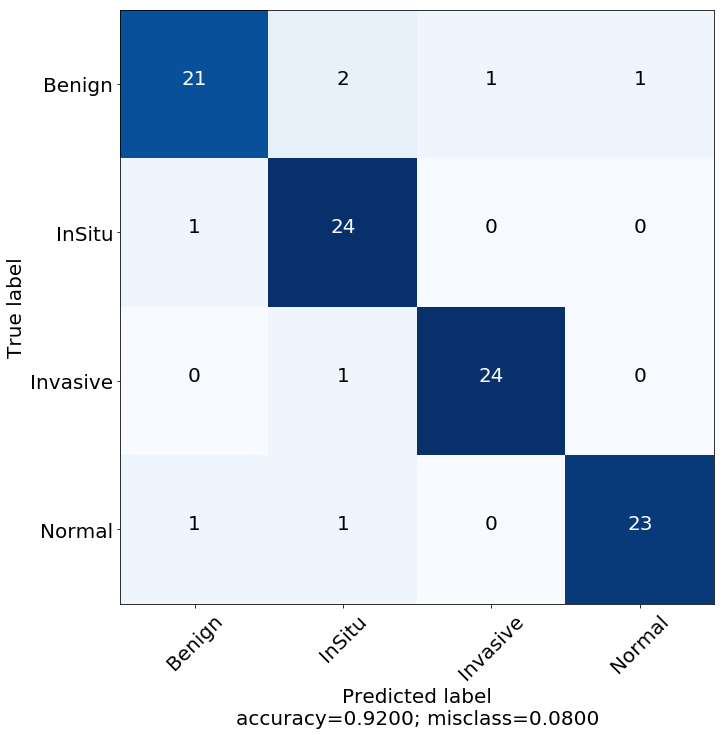

In [23]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [24]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[21  2  1  1]
 [ 1 24  0  0]
 [ 0  1 24  0]
 [ 1  1  0 23]]
              precision    recall  f1-score   support

      InSitu       0.91      0.84      0.87        25
    Invasive       0.86      0.96      0.91        25
      Benign       0.96      0.96      0.96        25
      Normal       0.96      0.92      0.94        25

   micro avg       0.92      0.92      0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100



In [25]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  95.45454545454545
Specificity :  92.3076923076923


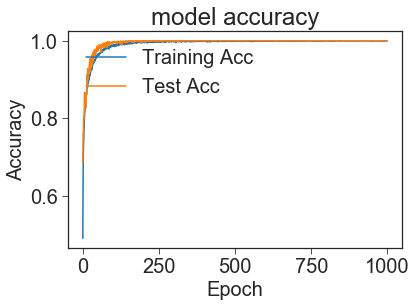

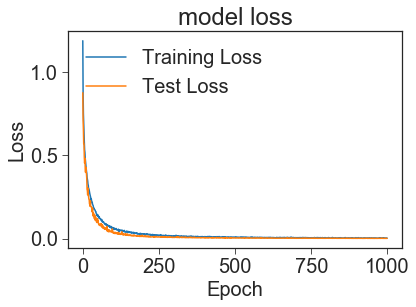

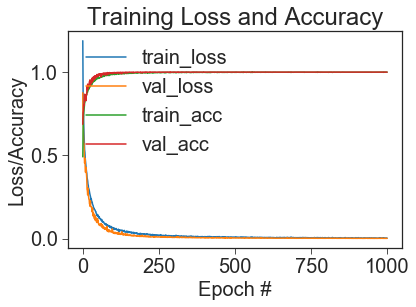

In [26]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")